# LPCVD 2k Design
### Factors and Levels
Varied the values found in COMSOL base design by $\pm 5\%$

| Factor                                | Low    | High   |
| ------------------------------------- | ------ | ------ |
| A: Temperature, $^\circ$C             | 576.65 | 637.35 |
| B: SiH$_4$ Inlet Mole Fraction, y$_1$ | 0.095  | 0.105  |
| C: Pressure, Pa                       | 66.5   | 73.5   |
| D: Velocity, m/s                      | 0.0475 | 0.0525 |
| E: H$_2$ Inlet Mole Fraction, y$_2$   | 0.0095 | 0.0105 |
| F: Wafer Spacing, mm                  | 2.375  | 2.625  |

# Import Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from copy import deepcopy
%matplotlib notebook

# Load Deposition Rate Data

In [2]:
def getTreatMap(n):
    facts = string.ascii_lowercase[:n]
    treats = ['']
    nxt_treats = []
    for fact in facts:
        nxt_treats = deepcopy(treats)
        for i, treat in enumerate(treats):
            nxt_treats.append(treat+fact)
        treats = nxt_treats
    treats[0] = '1'
    return {i: treat for i, treat in enumerate(treats)}

In [3]:
treatmap = getTreatMap(6)

data = pd.read_csv(
    'LPCVD Data v2.txt',
    sep=r'\s+', # any amount of whitespace
    header=None,
    names=['r', 'z']+[f'DelSi_{treatmap[i]}' for i in range(len(treatmap))],
    comment='%')

# Get eta and plot deposition

In [4]:
waferIndices = data[data['r'] == 0].index.to_list()
numberOfWafers = len(waferIndices)
pointsPerWafer = len(data.index)/numberOfWafers
eta = pd.DataFrame({'Wafer': list(range(numberOfWafers))})
eta.set_index('Wafer', inplace=True)

# plt.rcParams.update({'font.size': 11});
# fig, axs = plt.subplots(6,6, sharex=True, sharey=True, figsize=(12,10))

# for ax, label in zip(axs.flat, treatmap.values()): # Axes & Treatments
for label in treatmap.values():
    eta_i = pd.Series([0] * numberOfWafers, name=f'eta_{label}')
    for i in range(numberOfWafers):
        start = waferIndices[i]; # start index of wafer i data
        stop = start + pointsPerWafer - 1 # stop index of wafer i data
        r_i = data.loc[start:stop, 'r'] # r data for wafer i
        delta_Si_i = data.loc[start:stop, f'DelSi_{label}'] # DelSi data for wafer i
        
#         if i == 0:
#             c = 'red'
#             lw = 2
#         elif i == numberOfWafers-1:
#             c = 'orange'
#             lw = 2
#         else:
#             c = 'black'
#             lw = 0.5
            
#         pltlabel = None
#         if label == 1:
#             if i == 0:
#                 pltlabel = 'First Wafer'
#             elif i == numberOfWafers-1:
#                 pltlabel = 'Last Wafer'
        
#         ax.plot(r_i, delta_Si_i * 1e10, c=c, lw=lw, label=pltlabel)
        

        delta_Si_i_edge = delta_Si_i.iloc[-1] # edge dep. rate for wafer i
        delta_Si_i_avg = (2 / (r_i.iloc[-1] ** 2)) * np.trapz(delta_Si_i * r_i, r_i) # avg. dep. rate for wafer i
        eta_i.iloc[i] = delta_Si_i_avg / delta_Si_i_edge # effectiveness factor for wafer i

    eta[f'eta_{label}'] = eta_i
    eta_avg = eta[f'eta_{label}'].mean()
#     ax.set_title(f'{label}: '+'$\eta^{avg} =$' + f'{eta_avg:.6f}')

# fig.tight_layout()
# lgd = fig.legend(bbox_to_anchor=(1.25, 0.5), fontsize=16)
# tx1 = fig.text(0.5, -0.04, 'r (m)', ha='center', fontsize=16)
# tx2 = fig.text(-.04, 0.5, 'Si deposition rate ($\AA\ s^{-1}$)', va='center', rotation='vertical', fontsize=16);
# fig.savefig('Figures/Deposition Rates.png', bbox_extra_artists=(lgd, tx1, tx2), bbox_inches='tight', dpi=300);

In [5]:
eta.mean().to_csv('eta_mean v2.csv', header=None)

In [6]:
eta.std().to_csv('eta_std v2.csv', header=None)

In [7]:
has_a = eta.columns.str.contains('_.*a.*')
has_b = eta.columns.str.contains('_.*b.*')
has_c = eta.columns.str.contains('_.*c.*')
has_d = eta.columns.str.contains('_.*d.*')
has_e = eta.columns.str.contains('_.*e.*')
has_f = eta.columns.str.contains('_.*f.*')
has_factors = [has_a, has_b, has_c, has_d, has_e, has_f]
factors = string.ascii_lowercase[0:6]

In [8]:
eta_mean = eta.mean().tolist()
eta_std = eta.std().tolist()

<IPython.core.display.Javascript object>


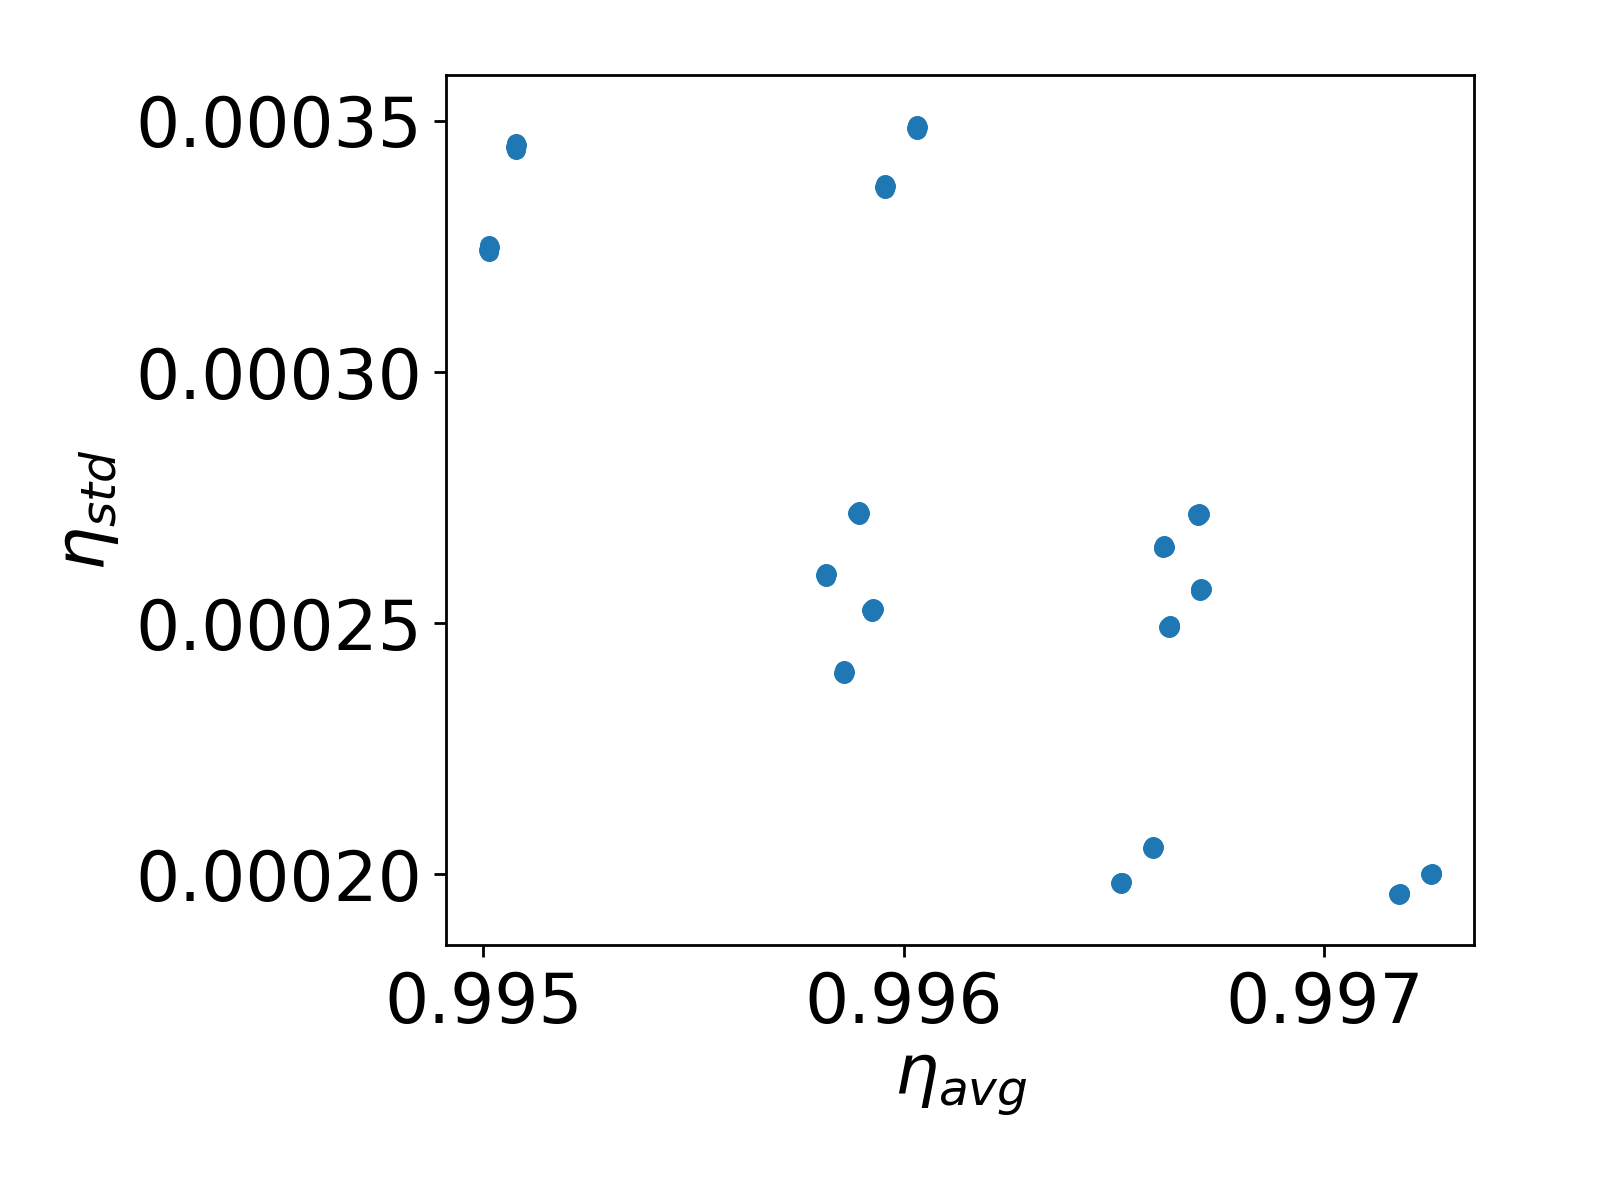

In [38]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
ax.scatter(eta.mean(), eta.std(), s=20)
ax.set_aspect(13/ax.get_data_ratio())
ax.set_xlabel('$\eta_{avg}$')
ax.set_ylabel('$\eta_{std}$');
ax.set_xlim([min(eta.mean())-1e-4, max(eta.mean())+1e-4])
ax.set_ylim([min(eta.std())-1e-5, max(eta.std())+1e-5]);
fig.tight_layout()
plt.savefig('Figures/eta.png', dpi=300);

In [19]:
eta_mean = eta.mean()
eta_mean = eta_mean[eta_mean > 0.997]
eta_mean1 = eta_mean[eta_mean < 0.9972]
eta_mean2 = eta_mean[eta_mean > 0.9972]
eta_std = eta.std()
eta_std1 = eta_std[eta_std.index.isin(eta_mean1.index)]
eta_std2 = eta_std[eta_std.index.isin(eta_mean2.index)]

<IPython.core.display.Javascript object>


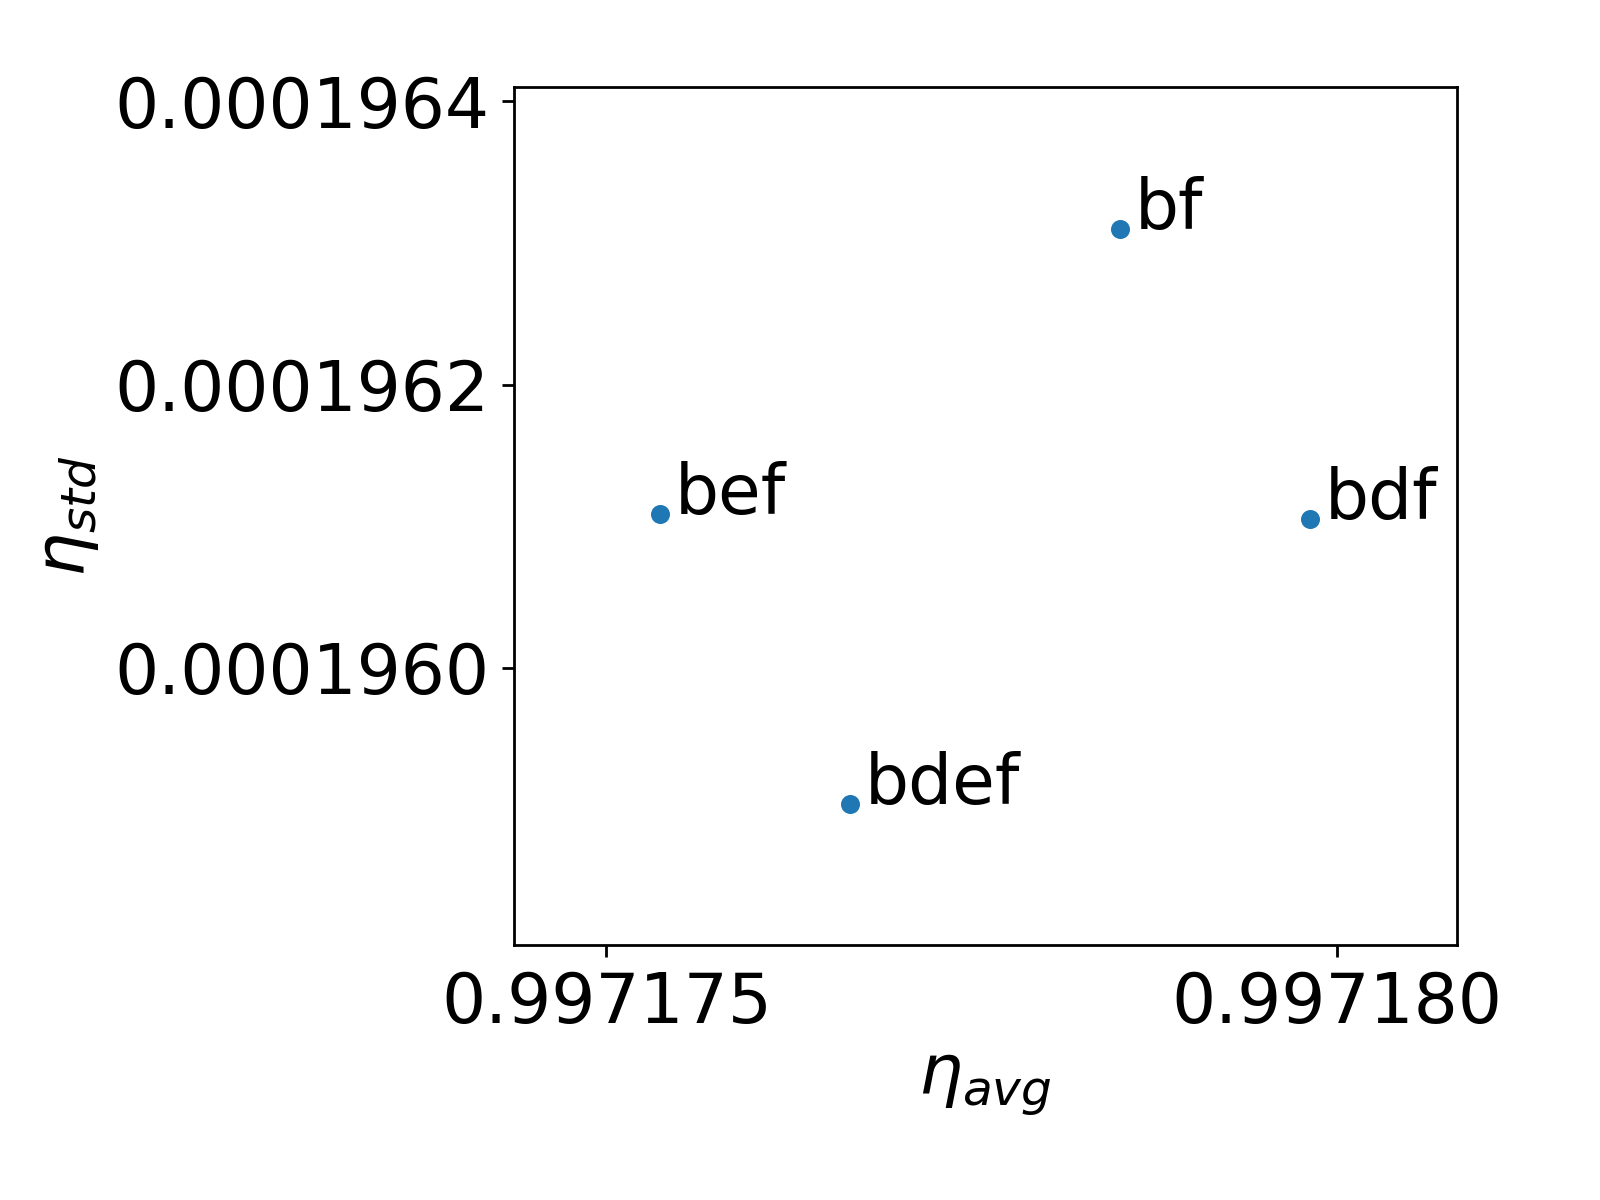

In [36]:
fig, ax = plt.subplots()
ax.scatter(eta_mean1, eta_std1, s=20)
for i in range(len(eta_mean1)):
    ax.text(eta_mean1[i]+1e-7, eta_std1[i], eta_mean1.index[i].split('_')[1])

ax.set_aspect(13/ax.get_data_ratio())
plt.locator_params(axis='x', nbins=2)
ax.ticklabel_format(useOffset=False)
plt.xlabel('$\eta_{avg}$')
plt.ylabel('$\eta_{std}$');
plt.xlim([min(eta_mean1)-1e-6, max(eta_mean1)+1e-6])
plt.ylim([min(eta_std1)-1e-7, max(eta_std1)+1e-7]);
fig.tight_layout()
fig.savefig('Figures/eta box1.png', dpi=300);

<IPython.core.display.Javascript object>


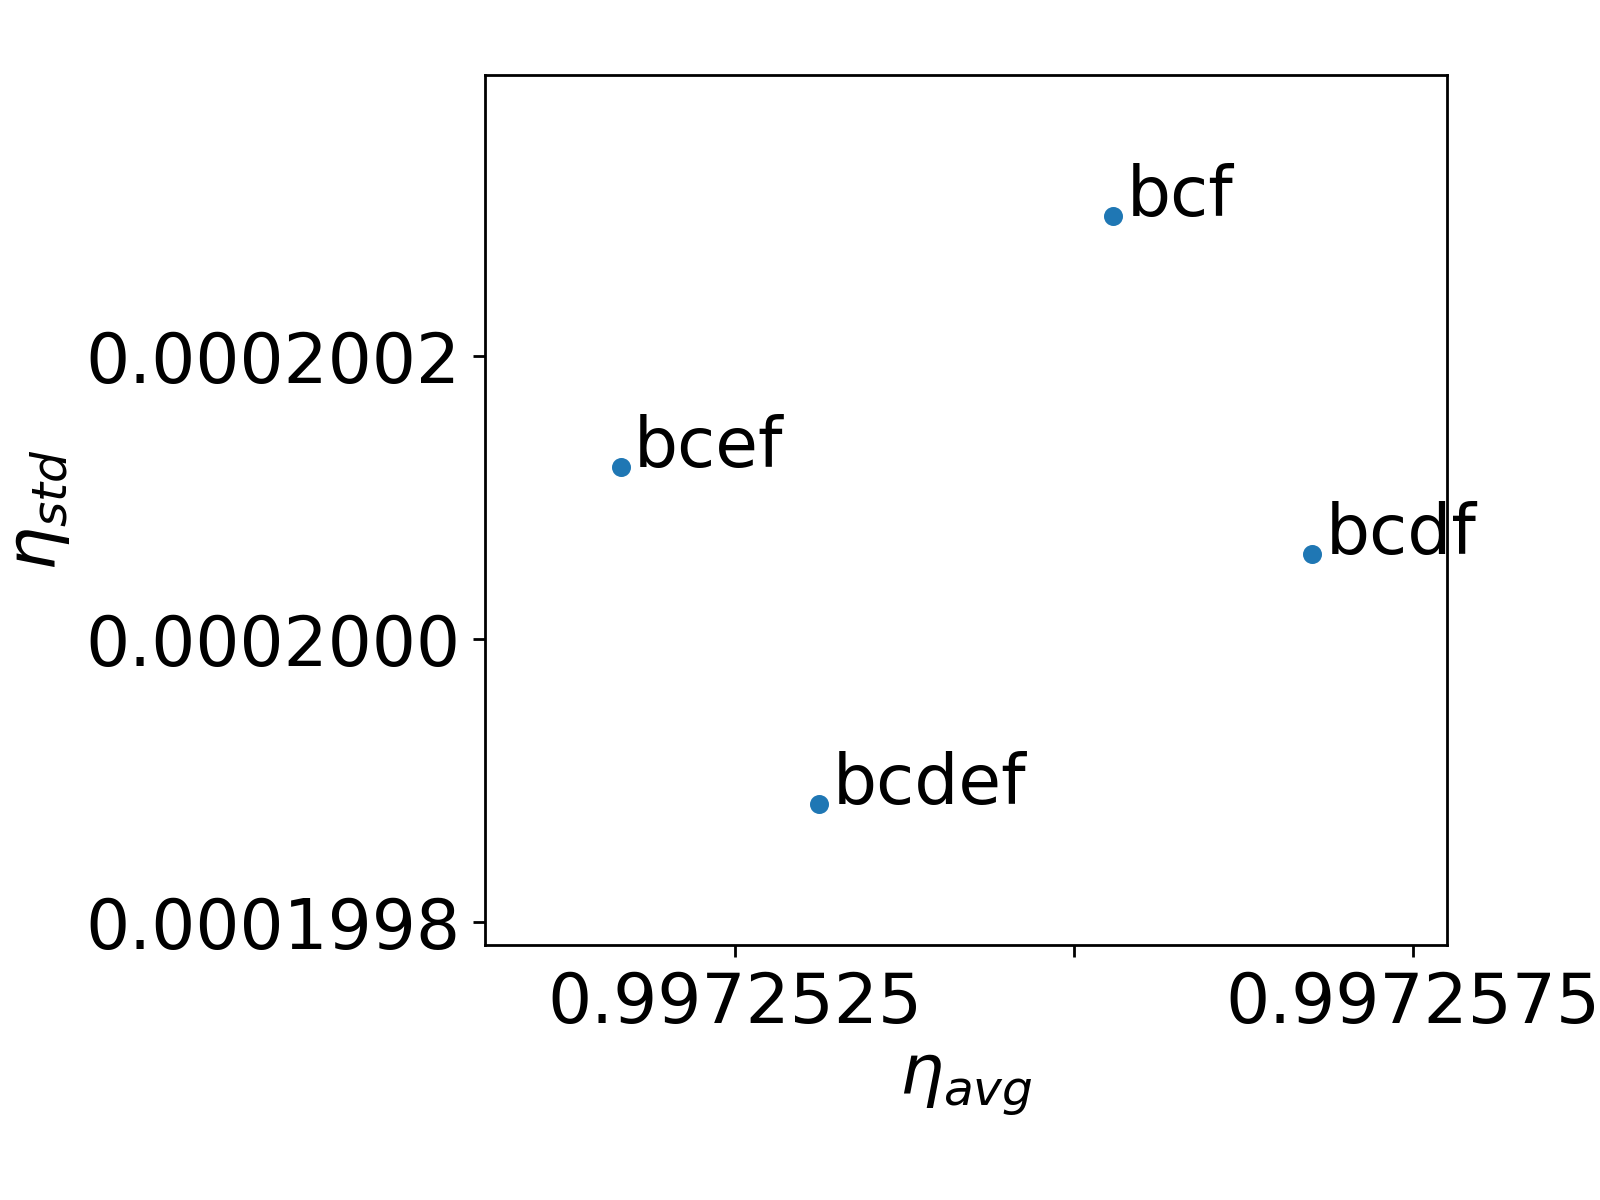

In [51]:
fig, ax = plt.subplots()
ax.scatter(eta_mean2, eta_std2, s=20)
for i in range(len(eta_mean2)):
    ax.text(eta_mean2[i]+1e-7, eta_std2[i], eta_mean2.index[i].split('_')[1])

ax.set_aspect(14/ax.get_data_ratio())
plt.locator_params(axis='x', nbins=2)
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n == 2:
        label.set_visible(False)
ax.ticklabel_format(useOffset=False)
plt.xlabel('$\eta_{avg}$')
plt.ylabel('$\eta_{std}$');
plt.xlim([min(eta_mean2)-1e-6, max(eta_mean2)+1e-6])
plt.ylim([min(eta_std2)-1e-7, max(eta_std2)+1e-7]);
fig.tight_layout()
fig.savefig('Figures/eta box2.png', dpi=300);

In [231]:
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'ab', 'ac', 'bc', 'ad', 'bd', 'cd', 'ae', 'be', 'ce', 'de', 'af', 'bf', 'cf', 'df', 'ef']
pvals = [7.43571E-88, 1.06857E-84, 1.10104E-44, 0.063280818, 0.006520923, 2.49905E-85, 4.61031E-42, 0.005820984, 0.001473649, 0.812271745, 0.833835322, 0.899213578, 0.784246278, 0.881274002, 0.791789375, 0.998872906, 1.30552E-45, 1.82099E-42, 0.621639192, 0.787691655, 0.989572156]
effects = [-0.000398993, 0.000335568, 3.72575E-05, 1.04016E-06, -1.561E-06, 0.000347382, 3.22218E-05, -1.58443E-06, 1.85568E-06, 1.30309E-07, -1.15096E-07, 6.9476E-08, 1.50239E-07, -8.19308E-08, -1.44856E-07, -7.74803E-10, 3.92144E-05, -3.29508E-05, -2.71094E-07, -1.47779E-07, 7.16866E-09]
pval_2k = pd.DataFrame({'label': labels, 'p-value': pvals, 'effect': effects})
pval_2k['s-value'] = -np.log2(pval_2k['p-value'])
pval_2k['significant'] = pval_2k['p-value'].apply(lambda x: True if x < 0.05 else False)

In [233]:
pval_2k.sort_values('p-value', inplace=True)

In [214]:
palette = ['green' if pval < 0.05 else 'grey' for pval in pval_2k['p-value'].values]

<IPython.core.display.Javascript object>


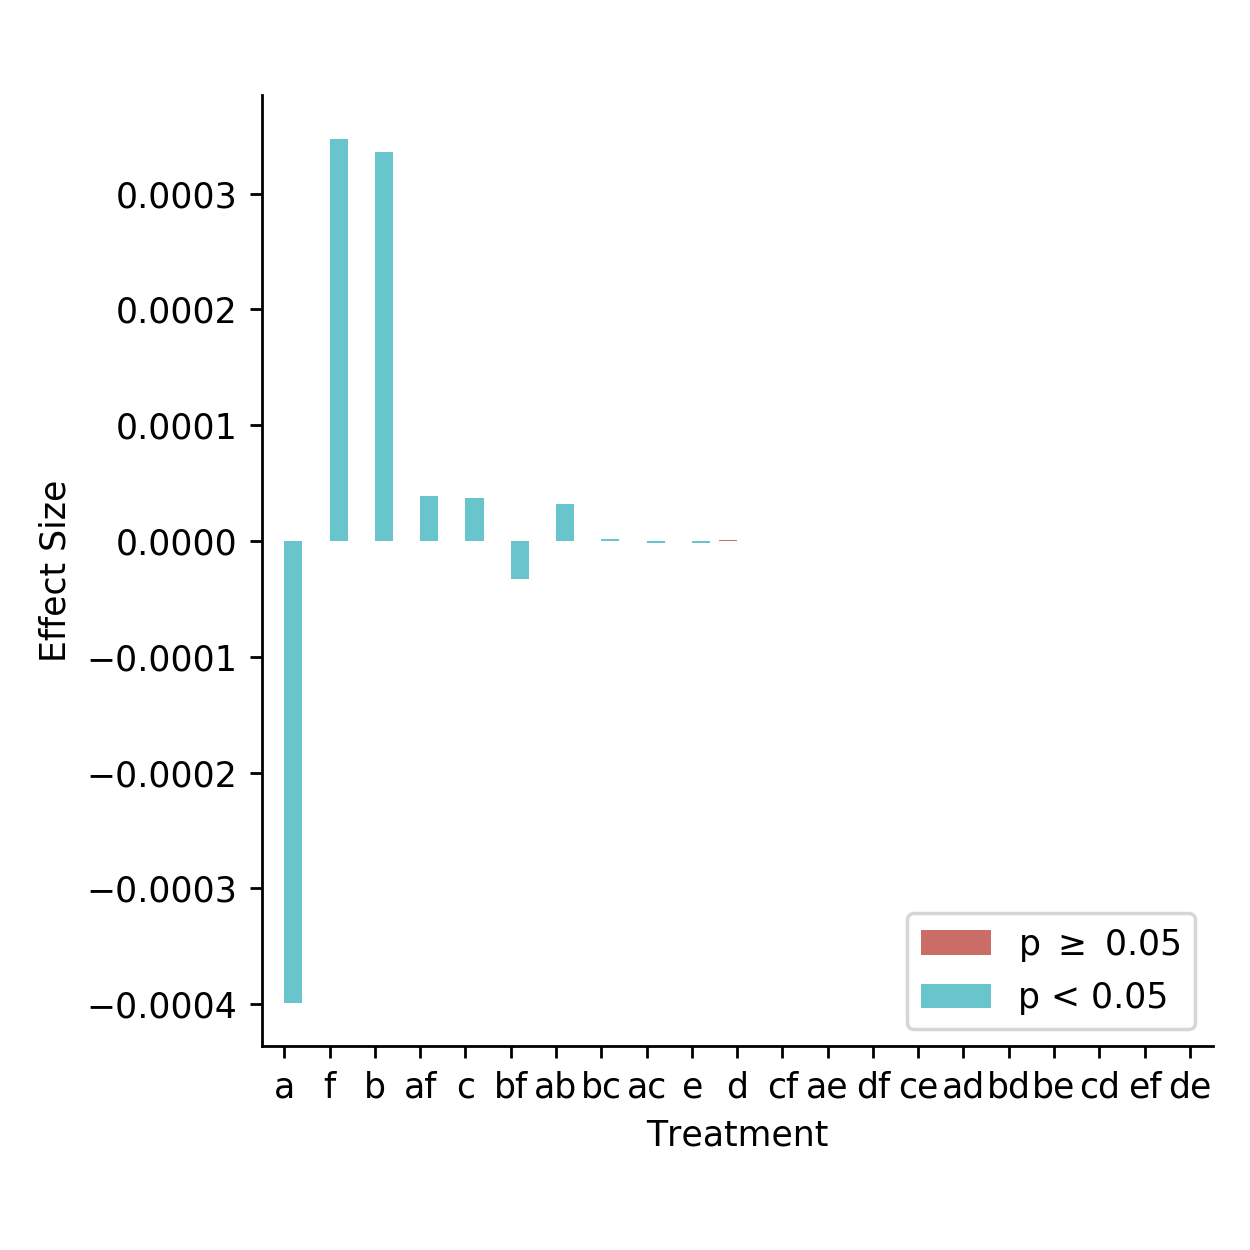

In [275]:
%matplotlib notebook
g = sns.catplot(kind='bar', x='label', y='effect', palette = 'hls', hue='significant', legend=False, data=pval_2k)

g.ax.set(xlabel='Treatment', ylabel='Effect Size')
g.ax.set_aspect(1/g.ax.get_data_ratio())
new_labels = ['p $\geq$ 0.05', 'p < 0.05']
handles, labels = g.ax.get_legend_handles_labels()
g.ax.legend(handles=handles, labels=new_labels)
g.savefig('Figures/Significant Effects.png', dpi=300);